In [0]:
# 참고 튜토리얼
# https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/generative_adversarial_network/main.py

In [0]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

In [3]:
device

device(type='cuda')

In [0]:
# hyperparameter
latent_size = 64
hidden_size = 256
image_size = 784
num_epochs = 50
batch_size = 100

In [0]:
# image processing
transform = transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize(mean=[0.5],
                                                    std=[0.5])
])

In [16]:
# Mnist dataset
train = torchvision.datasets.MNIST(root='data/',
                                   train=True,
                                   transform=transform,
                                   download=True)
test = torchvision.datasets.MNIST(root='data/',
                                   train=False,
                                   transform=transform,
                                   download=True)

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=mnist,
                                          batch_size=batch_size,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=mnist,
                                          batch_size=batch_size,
                                          shuffle=True)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


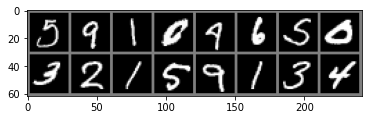

In [17]:
import numpy as np
from matplotlib import pyplot as plt

def imshow(img):
    img = (img+1)/2    
    img = img.squeeze()
    np_img = img.numpy()
    plt.imshow(np_img, cmap='gray')
    plt.show()

def imshow_grid(img): 
    img = torch.utils.make_grid(img.cpu().detach())
    img = (img+1)/2
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1,2,0)))
    plt.show()
    
example_mini_batch_img, example_mini_batch_label  = next(iter(train_loader))
imshow_grid(example_mini_batch_img[0:16,:,:])

In [0]:
# disciminator

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size,1),
    nn.Sigmoid()
)

# generator

G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size,image_size),
    nn.Tanh()
)

In [0]:
D = D.to(device)
G = G.to(device)

In [0]:
# Binary cross entropy loss and optimizer

criterion = nn.BCELoss()
D_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
G_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [0]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

In [0]:
# training
def training():
    
    total_step = len(train_loader)
    G.train()
    D.train()
    for i, (images, _) in enumerate(train_loader):
        images = images.reshape(batch_size, -1).to(device)

        # Create the labels which are later used as input for the BCE loss
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # train discriminator
        D_optimizer.zero_grad()
        
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        D_optimizer.step()

        # train generator
        G_optimizer.zero_grad()

        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        g_loss = criterion(outputs, real_labels)

        g_loss.backward()
        G_optimizer.step()

        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
            .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                    real_score.mean().item(), fake_score.mean().item()))

In [0]:
# evaluation

def sample_z(batch_size=1, d_noise=64):
    return torch.randn(batch_size, d_noise, device=device)

def evaluate_model(generator, discriminator):
    
    p_real, p_fake = 0.,0.
    
    generator.eval()
    discriminator.eval()
        
    for i, (images, _) in enumerate(train_loader):
        images = images.reshape(batch_size, -1).to(device)
        
        with torch.autograd.no_grad():
            p_real += (torch.sum(discriminator(images)).item())/10000.
            p_fake += (torch.sum(discriminator(generator(sample_z(batch_size, latent_size)))).item())/10000.
                
    return p_real, p_fake

In [0]:
from tqdm import tqdm_notebook

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


Epoch [0/30], Step [200/600], d_loss: 0.1978, g_loss: 4.1154, D(x): 0.94, D(G(z)): 0.06
Epoch [0/30], Step [400/600], d_loss: 0.1822, g_loss: 5.3835, D(x): 0.98, D(G(z)): 0.11
Epoch [0/30], Step [600/600], d_loss: 0.1645, g_loss: 5.0420, D(x): 0.97, D(G(z)): 0.06
Epoch [1/30], Step [200/600], d_loss: 0.3212, g_loss: 6.6904, D(x): 0.91, D(G(z)): 0.01
Epoch [1/30], Step [400/600], d_loss: 0.1667, g_loss: 5.2376, D(x): 0.94, D(G(z)): 0.04
Epoch [1/30], Step [600/600], d_loss: 0.0988, g_loss: 4.6058, D(x): 0.96, D(G(z)): 0.04
Epoch [2/30], Step [200/600], d_loss: 0.1006, g_loss: 6.3551, D(x): 0.97, D(G(z)): 0.00
Epoch [2/30], Step [400/600], d_loss: 0.0880, g_loss: 4.7566, D(x): 0.98, D(G(z)): 0.04
Epoch [2/30], Step [600/600], d_loss: 0.3118, g_loss: 4.3750, D(x): 0.94, D(G(z)): 0.14
Epoch [3/30], Step [200/600], d_loss: 0.2399, g_loss: 8.5407, D(x): 0.91, D(G(z)): 0.00
Epoch [3/30], Step [400/600], d_loss: 0.2219, g_loss: 6.5778, D(x): 0.95, D(G(z)): 0.06
Epoch [3/30], Step [600/600], d_

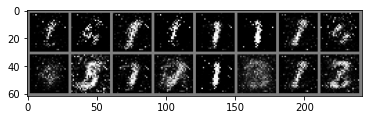

Epoch [10/30], Step [200/600], d_loss: 0.2418, g_loss: 3.3843, D(x): 0.90, D(G(z)): 0.04
Epoch [10/30], Step [400/600], d_loss: 0.3904, g_loss: 5.0704, D(x): 0.89, D(G(z)): 0.07
Epoch [10/30], Step [600/600], d_loss: 0.2820, g_loss: 5.6305, D(x): 0.89, D(G(z)): 0.04
Epoch [11/30], Step [200/600], d_loss: 0.4450, g_loss: 3.8524, D(x): 0.87, D(G(z)): 0.09
Epoch [11/30], Step [400/600], d_loss: 0.3123, g_loss: 3.8601, D(x): 0.92, D(G(z)): 0.08
Epoch [11/30], Step [600/600], d_loss: 0.3574, g_loss: 3.3229, D(x): 0.94, D(G(z)): 0.19
Epoch [12/30], Step [200/600], d_loss: 0.5907, g_loss: 3.2679, D(x): 0.88, D(G(z)): 0.21
Epoch [12/30], Step [400/600], d_loss: 0.2295, g_loss: 4.9043, D(x): 0.94, D(G(z)): 0.12
Epoch [12/30], Step [600/600], d_loss: 0.3355, g_loss: 4.0329, D(x): 0.88, D(G(z)): 0.06
Epoch [13/30], Step [200/600], d_loss: 0.3675, g_loss: 3.3576, D(x): 0.87, D(G(z)): 0.08
Epoch [13/30], Step [400/600], d_loss: 0.5158, g_loss: 2.2884, D(x): 0.86, D(G(z)): 0.13
Epoch [13/30], Step [

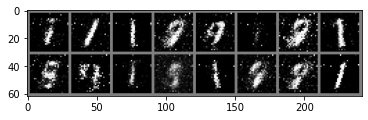

Epoch [20/30], Step [200/600], d_loss: 0.4587, g_loss: 3.7378, D(x): 0.85, D(G(z)): 0.11
Epoch [20/30], Step [400/600], d_loss: 0.4477, g_loss: 3.4159, D(x): 0.84, D(G(z)): 0.05
Epoch [20/30], Step [600/600], d_loss: 0.3829, g_loss: 2.5685, D(x): 0.89, D(G(z)): 0.13
Epoch [21/30], Step [200/600], d_loss: 0.4181, g_loss: 3.8947, D(x): 0.87, D(G(z)): 0.10
Epoch [21/30], Step [400/600], d_loss: 0.3273, g_loss: 3.8207, D(x): 0.93, D(G(z)): 0.14
Epoch [21/30], Step [600/600], d_loss: 0.3764, g_loss: 3.6961, D(x): 0.85, D(G(z)): 0.09
Epoch [22/30], Step [200/600], d_loss: 0.5780, g_loss: 4.0342, D(x): 0.84, D(G(z)): 0.11
Epoch [22/30], Step [400/600], d_loss: 0.3600, g_loss: 3.2488, D(x): 0.89, D(G(z)): 0.14
Epoch [22/30], Step [600/600], d_loss: 0.4072, g_loss: 3.3626, D(x): 0.84, D(G(z)): 0.06
Epoch [23/30], Step [200/600], d_loss: 0.3188, g_loss: 4.2853, D(x): 0.90, D(G(z)): 0.12
Epoch [23/30], Step [400/600], d_loss: 0.6304, g_loss: 2.7359, D(x): 0.90, D(G(z)): 0.29
Epoch [23/30], Step [

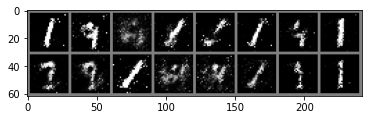

In [45]:
p_real_trace = []
p_fake_trace = []
num_epochs = 30

for epoch in tqdm_notebook(range(num_epochs)):
    training()
    p_real, p_fake = evaluate_model(G,D)

    p_real_trace.append(p_real)
    p_fake_trace.append(p_fake)
            
    if((epoch+1)% 10 == 0):
        print('(epoch %i/50) p_real: %f, p_g: %f' % (epoch+1, p_real, p_fake))
        imshow_grid(G(sample_z(16)).view(-1, 1, 28, 28))

# Save the model checkpoints 
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

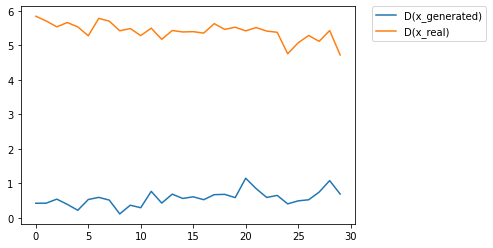

In [46]:
plt.plot(p_fake_trace, label='D(x_generated)')
plt.plot(p_real_trace, label='D(x_real)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

## 망했다 수렴하지 않는다
- epoch를 좀 더 늘리면 어떨까 생각이 든다.